In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

from hts.hierarchy import HierarchyTree
from hts import HTSRegressor
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [2]:
sales = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/sales_train_evaluation.csv')
cal = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/calendar.csv')

In [60]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [4]:
#take the dataframe and only present the relevant category
def filter_aggregate_sales(frame, column_to_filter, column_value_to_filter, column_to_aggregate):
    frame = frame[frame[column_to_filter] == column_value_to_filter]
    frame = frame.groupby(column_to_aggregate).sum().T
    return frame

In [5]:
filter_aggregate_sales(frame=sales, column_to_filter='state_id', column_value_to_filter='CA', column_to_aggregate='state_id')

state_id,CA
d_1,14195
d_2,13805
d_3,10108
d_4,11047
d_5,9925
...,...
d_1937,15678
d_1938,16297
d_1939,17430
d_1940,23103


In [6]:
#merge sales with calendar 
def merge_pd(frame1, frame2, merge_index):
    mergedframe = pd.merge(frame1, frame2, on = merge_index, how = 'inner')
    mergedframe.date = pd.to_datetime(mergedframe.date)
    mergedframe = mergedframe.drop(['wm_yr_wk', 'weekday', 'year', 'd', 'event_name_1', 'event_name_2', 
                                      'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'wday', 'month',
                                   'event_type_1'], axis='columns')
    return mergedframe

In [7]:
#Create hierarchical dataframe by summing for each category or sub-category
def summedlist(frame, col_to_filter):
    for state in frame[col_to_filter].unique():
        states[state] = filter_aggregate_sales(frame=frame, column_to_filter=col_to_filter, column_value_to_filter=state,
                                           column_to_aggregate=col_to_filter)[state]
    return states

In [8]:
list_of_cols = ['state_id', 'store_id', 'cat_id', 'dept_id'] 
type(list_of_cols)

list

In [10]:
#test = summedlist(sales, list_of_cols)
#test

In [11]:
states = filter_aggregate_sales(frame=sales, column_to_filter='state_id', column_value_to_filter='CA',
                                   column_to_aggregate='state_id')
states['CA']

d_1       14195
d_2       13805
d_3       10108
d_4       11047
d_5        9925
          ...  
d_1937    15678
d_1938    16297
d_1939    17430
d_1940    23103
d_1941    24644
Name: CA, Length: 1941, dtype: int64

In [12]:
sales.state_id.unique()

array(['CA', 'TX', 'WI'], dtype=object)

In [13]:
#Create hierarchical dataframe
summedlistframe = pd.DataFrame()
for state in sales.state_id.unique():
    summedlistframe[state] = filter_aggregate_sales(frame=sales, column_to_filter='state_id', column_value_to_filter=state,
                                                  column_to_aggregate='state_id')[state]

for store in sales.store_id.unique():
    summedlistframe[store] = filter_aggregate_sales(frame=sales, column_to_filter='store_id', column_value_to_filter=store,
                                                    column_to_aggregate='store_id')[store]  

for category in sales.cat_id.unique():
    summedlistframe[category] = filter_aggregate_sales(frame=sales, column_to_filter='cat_id', column_value_to_filter=category,
                                                       column_to_aggregate='cat_id')[category]
for dept in sales.dept_id.unique():
    summedlistframe[dept] = filter_aggregate_sales(frame=sales, column_to_filter='dept_id', column_value_to_filter=dept,
                                                       column_to_aggregate='dept_id')[dept]
summedlistframe['total'] = summedlistframe.CA + summedlistframe.TX + summedlistframe.WI
#states2 = states.reset_index()
#states2 = states2.rename(columns={'index':'d'})
summedlistframe.head()

,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,...,HOUSEHOLD,FOODS,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,FOODS_1,FOODS_2,FOODS_3,total
d_1,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,...,5689,23178,3610,154,4105,1584,2343,4094,16741,32631
d_2,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,...,5634,22758,3172,185,3858,1776,2216,4209,16333,31749
d_3,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,...,3927,17174,2497,185,2827,1100,1657,3174,12343,23783
d_4,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,...,3865,18878,2531,138,2732,1133,1508,3606,13764,25412
d_5,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,...,2729,14603,1714,100,1802,927,1209,2869,10525,19146


In [14]:
summedlistframe = summedlistframe.reset_index()
summedlistframe = summedlistframe.rename({'index':'d'}, axis='columns')

In [15]:
summedlistframe.head()

,d,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,...,HOUSEHOLD,FOODS,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,FOODS_1,FOODS_2,FOODS_3,total
0,d_1,14195,9438,8998,4337,3494,4739,1625,2556,3852,...,5689,23178,3610,154,4105,1584,2343,4094,16741,32631
1,d_2,13805,9630,8314,4155,3046,4827,1777,2687,3937,...,5634,22758,3172,185,3858,1776,2216,4209,16333,31749
2,d_3,10108,6778,6897,2816,2121,3785,1386,1822,2731,...,3927,17174,2497,185,2827,1100,1657,3174,12343,23783
3,d_4,11047,7381,6984,3051,2324,4232,1440,2258,2954,...,3865,18878,2531,138,2732,1133,1508,3606,13764,25412
4,d_5,9925,5912,3309,2630,1942,3817,1536,1694,2492,...,2729,14603,1714,100,1802,927,1209,2869,10525,19146


In [61]:
#add date as the index 
combinedframe = merge_pd(frame1=summedlistframe, frame2=cal, merge_index='d')
combinedframe = combinedframe.set_index('date')
combinedframe.head()

,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,...,HOUSEHOLD,FOODS,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,FOODS_1,FOODS_2,FOODS_3,total
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,...,5689,23178,3610,154,4105,1584,2343,4094,16741,32631
2011-01-30,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,...,5634,22758,3172,185,3858,1776,2216,4209,16333,31749
2011-01-31,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,...,3927,17174,2497,185,2827,1100,1657,3174,12343,23783
2011-02-01,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,...,3865,18878,2531,138,2732,1133,1508,3606,13764,25412
2011-02-02,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,...,2729,14603,1714,100,1802,927,1209,2869,10525,19146


In [62]:
combinedframe.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=1941, freq=None)

In [63]:
#Categorize the names in each col
state = sales.state_id.unique()
store = sales.store_id.unique()
dept = sales.dept_id.unique()
cat = sales.cat_id.unique()
items = sales.id.unique()

In [64]:
#create a dictionary for each category to form a tree 
total = {'total': list(state)}
state_h = {k: [v for v in store if v.startswith(k)] for k in state}
store_h = {k: [v for v in cat if v.startswith(k)] for k in store}
dept_h = {k: [v for v in dept if v.startswith(k)] for k in cat}
item_h = {k: [v for v in items if v.startswith(k)] for k in dept}

In [65]:
state_h

{'CA': ['CA_1', 'CA_2', 'CA_3', 'CA_4'],
 'TX': ['TX_1', 'TX_2', 'TX_3'],
 'WI': ['WI_1', 'WI_2', 'WI_3']}

In [66]:
#create tree 
hierarchy = {**total, **state_h}
hierarchy

{'total': ['CA', 'TX', 'WI'],
 'CA': ['CA_1', 'CA_2', 'CA_3', 'CA_4'],
 'TX': ['TX_1', 'TX_2', 'TX_3'],
 'WI': ['WI_1', 'WI_2', 'WI_3']}

In [67]:
#create hierarchical tree
ht = HierarchyTree.from_nodes(nodes=hierarchy, df=combinedframe)

In [68]:
ht.children

[- CA
    |- CA_1
    |- CA_2
    |- CA_3
    - CA_4,
 - TX
    |- TX_1
    |- TX_2
    - TX_3,
 - WI
    |- WI_1
    |- WI_2
    - WI_3]

In [69]:
ht.children[0].children[2]

- CA_3

In [70]:
combinedframe

,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,...,HOUSEHOLD,FOODS,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,FOODS_1,FOODS_2,FOODS_3,total
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,...,5689,23178,3610,154,4105,1584,2343,4094,16741,32631
2011-01-30,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,...,5634,22758,3172,185,3858,1776,2216,4209,16333,31749
2011-01-31,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,...,3927,17174,2497,185,2827,1100,1657,3174,12343,23783
2011-02-01,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,...,3865,18878,2531,138,2732,1133,1508,3606,13764,25412
2011-02-02,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,...,2729,14603,1714,100,1802,927,1209,2869,10525,19146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,15678,10375,11043,3995,3789,5375,2519,3147,3518,3710,...,8566,24790,3291,449,6641,1925,3073,4648,17069,37096
2016-05-19,16297,9162,11504,4136,4037,5580,2544,2748,3126,3288,...,8751,24737,3027,448,6759,1992,3251,4551,16935,36963
2016-05-20,17430,12303,12819,4433,4751,5542,2704,3664,4249,4390,...,10273,28136,3761,382,7974,2299,3735,4815,19586,42552


In [75]:
combinedframe.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=1941, freq=None)

In [76]:
# I don't know what this does but it fixed my bug that i couldn't fix for ages
combinedframe = combinedframe.resample("D").sum()

In [77]:
combinedframe 

,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,...,HOUSEHOLD,FOODS,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,FOODS_1,FOODS_2,FOODS_3,total
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,...,5689,23178,3610,154,4105,1584,2343,4094,16741,32631
2011-01-30,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,...,5634,22758,3172,185,3858,1776,2216,4209,16333,31749
2011-01-31,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,...,3927,17174,2497,185,2827,1100,1657,3174,12343,23783
2011-02-01,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,...,3865,18878,2531,138,2732,1133,1508,3606,13764,25412
2011-02-02,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,...,2729,14603,1714,100,1802,927,1209,2869,10525,19146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,15678,10375,11043,3995,3789,5375,2519,3147,3518,3710,...,8566,24790,3291,449,6641,1925,3073,4648,17069,37096
2016-05-19,16297,9162,11504,4136,4037,5580,2544,2748,3126,3288,...,8751,24737,3027,448,6759,1992,3251,4551,16935,36963
2016-05-20,17430,12303,12819,4433,4751,5542,2704,3664,4249,4390,...,10273,28136,3761,382,7974,2299,3735,4815,19586,42552


In [78]:
#fit to HTSregressor 
regressor = HTSRegressor(model='holt_winters', revision_method='OLS', n_jobs=1)
model = regressor.fit(combinedframe, hierarchy)

Fitting models: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


In [79]:
prediction = model.predict()

Fitting models: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


In [80]:
prediction

,total,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
2011-01-29,32506.370349,14216.377969,9236.842350,9053.150031,4440.251682,3323.286638,4842.251682,1610.587965,2826.669337,4034.070995,2376.102018,2767.727498,2183.695034,4101.727498
2011-01-30,32518.807776,14211.357518,9246.786977,9060.663281,4432.834706,3333.411626,4834.834706,1610.276480,2806.831831,4020.317354,2419.637792,2749.134401,2228.394480,4083.134401
2011-01-31,31862.224017,13984.226785,9108.772016,8769.225216,4237.961058,3307.361321,4826.556175,1612.348231,2742.116240,3960.340600,2406.315177,2633.136347,2016.872290,4119.216580
2011-02-01,25997.336013,11871.070535,7435.170348,6691.095130,2744.626060,3076.527857,4606.406771,1443.509847,2181.914295,3372.002974,1881.253078,2131.658503,1552.027068,3007.409559
2011-02-02,26965.202072,12270.623684,7807.776407,6886.801981,3036.487642,3088.047141,4642.803083,1503.285817,2313.847104,3471.191408,2022.737895,2150.767041,1864.695215,2871.339725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-19,38891.794475,16763.243377,10293.744498,11834.806600,3775.014289,4398.402514,6027.693950,2562.132624,2977.095317,3652.891767,3663.757414,3810.441450,4856.964238,3167.400912
2016-05-20,38615.550525,16797.988333,10264.377957,11553.184235,3912.415294,4358.082801,5982.831375,2544.658863,2984.568084,3632.955797,3646.854075,3738.981794,4632.488094,3181.714347
2016-05-21,42545.391351,18122.200734,11529.527216,12893.663401,4474.249004,4634.586528,6206.927080,2806.438122,3403.082649,4051.281991,4075.162576,3978.650758,4900.752761,4014.259882
2016-05-22,49117.177834,20538.263094,13424.703151,15154.211589,6012.179865,5008.568647,6475.885344,3041.629238,4029.154376,4686.989326,4708.559449,4568.284131,5602.580212,4983.347246


This is for:   total


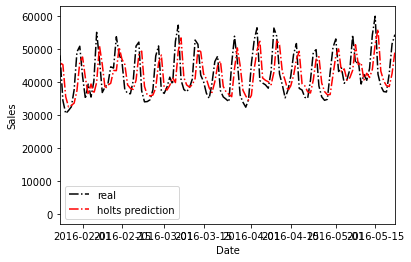

This is for:   CA


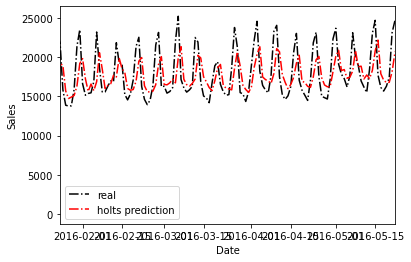

This is for:   TX


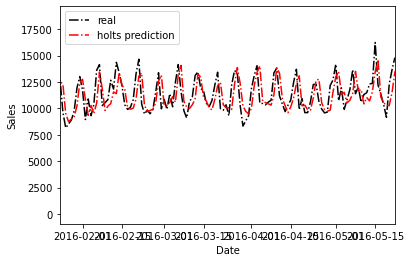

This is for:   WI


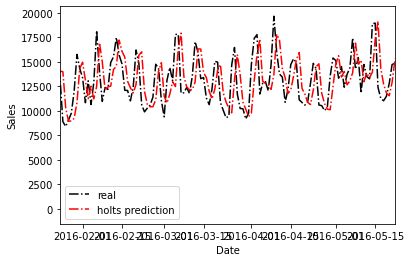

This is for:   CA_1


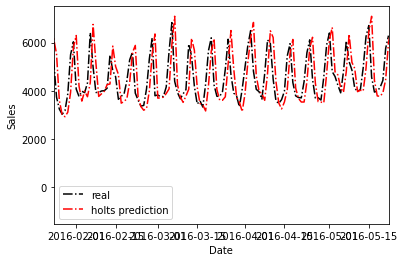

This is for:   CA_2


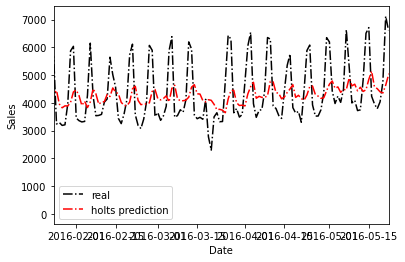

This is for:   CA_3


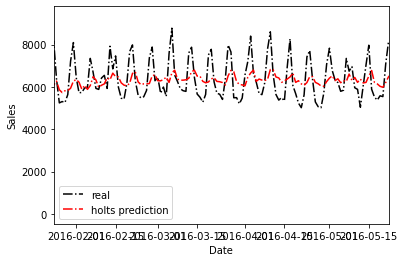

This is for:   CA_4


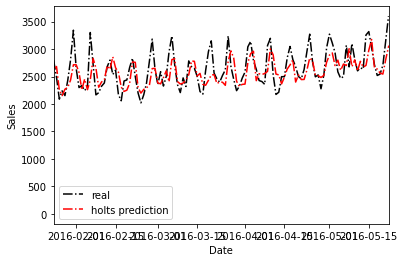

This is for:   TX_1


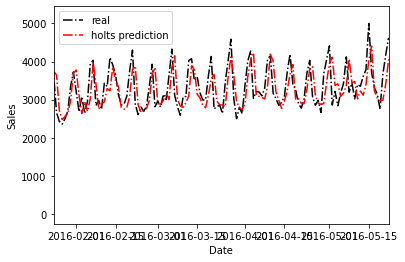

This is for:   TX_2


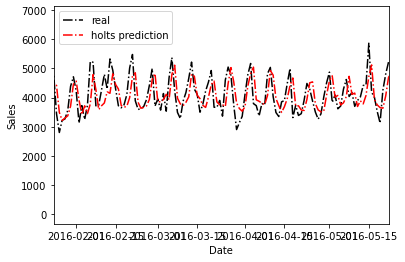

This is for:   TX_3


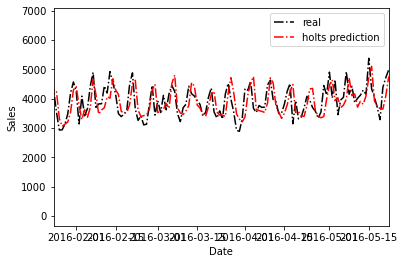

This is for:   WI_1


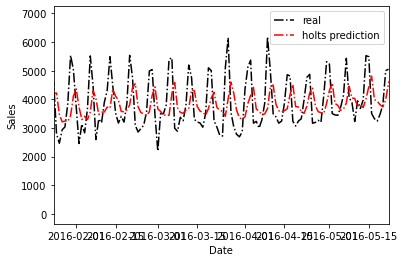

This is for:   WI_2


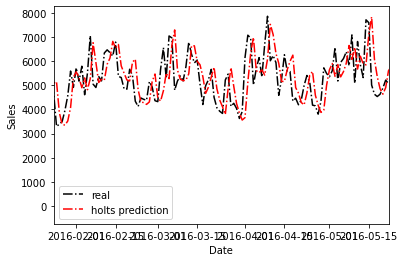

This is for:   WI_3


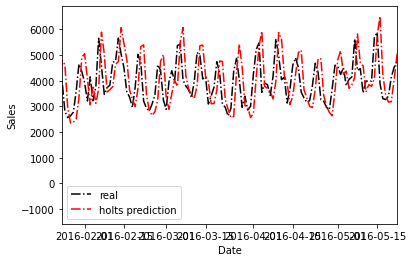

In [82]:
for col_names in prediction:
    print("This is for:  ", col_names)
    plt.plot(combinedframe[col_names],'k-.', label='real')
    plt.plot(prediction[col_names],'r-.', label='holts prediction')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xlim('2016-01-24', '2016-05-22')
    plt.legend()
    plt.show()


